<a href="https://colab.research.google.com/github/dernameistegal/airbnb_price/blob/main/model_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model for 2


In [1]:
!git clone https://github.com/dernameistegal/airbnb_price.git

Cloning into 'airbnb_price'...
remote: Enumerating objects: 1210, done.
remote: Counting objects: 100% (1210/1210), done.
remote: Compressing objects: 100% (1143/1143), done.
remote: Total 1210 (delta 728), reused 318 (delta 58), pack-reused 0
Receiving objects: 100% (1210/1210), 10.09 MiB | 11.37 MiB/s, done.
Resolving deltas: 100% (728/728), done.


In [2]:
%cd airbnb_price
import sys
sys.path.append("/content/airbnb_price/custom_functions")
import general_utils as ut
device = ut.get_device()
#import explainability_utils as explain

/content/airbnb_price
cuda available: True ; cudnn available: True ; num devices: 1
Using device Tesla P100-PCIE-16GB


In [3]:
%%capture
!pip install transformers
!pip install requests
!pip install captum

# Data Loading

In [5]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import fastprogress
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertModel
import torch.nn as nn
import torch
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Explore the dataset

In [6]:
path = "/content/drive/MyDrive/Colab/airbnb/data/reviews/df.pickle"
data = pd.read_pickle(path)
input_ids, attention_masks, labels = data['review_input_ids'], data['review_attention_masks'], data['log_price']

In [7]:
nreviews = np.vectorize(len)(input_ids)

In [8]:
input_ids = np.concatenate(np.array(input_ids))
attention_masks = np.concatenate(np.array(attention_masks))
labels = np.repeat(np.array(labels), nreviews)

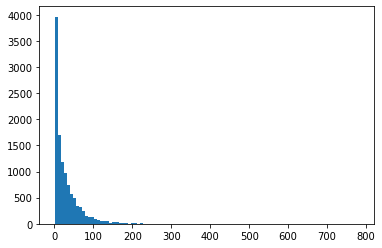

In [9]:
# TODO Visualize the length of the reviews in your dataset
def count_words(string):
    string = string[0]
    return len(string.split())

review_lengths = np.vectorize(count_words)(data["reviews"])

a = plt.hist(review_lengths, bins = 100)
plt.show()

In [10]:
%tensorflow_version 1.x
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

TensorFlow 1.x selected.


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

## Training, Validation, Test Split

Use 15% of the dataset as validation and test set, respectively. Use the other 70% for training.

In [11]:
train_ids, val_ids, test_ids = ut.train_val_test_split(data.index)  
traindf, valdf = data.loc[train_ids], data.loc[val_ids]
ids_train, labels_train, masks_train = traindf['review_input_ids'], traindf['log_price'], traindf['review_attention_masks']
ids_val, labels_val, masks_val = valdf['review_input_ids'], valdf['log_price'], valdf['review_attention_masks']
nreviews_train = np.vectorize(len)(ids_train)
nreviews_val = np.vectorize(len)(ids_val)

In [12]:
ids_train, ids_val =  np.concatenate(np.array(ids_train)), np.concatenate(np.array(ids_val))
labels_train, labels_val = np.repeat(np.array(labels_train), nreviews_train), np.repeat(np.array(labels_val), nreviews_val)
masks_train, masks_val = np.concatenate(np.array(masks_train)), np.concatenate(np.array(masks_val))

In [13]:
# TODO: Print out the shapes of your splitted train, validation, and test set
# Hint: your validation set should contain 500 samples. How many tokens are
# included per sample? 

# (1) print the feature shapes
print(ids_train.shape)
print(ids_val.shape)

# (2) print the label shapes
print(labels_train.shape)
print(labels_val.shape)

# (3) print the attention mask shapes
print(masks_train.shape)
print(masks_val.shape)

(256285, 128)
(54785, 128)
(256285,)
(54785,)
(256285, 128)
(54785, 128)


## Create DataLoader

You can use `TensorDataset`, `torch.from_numpy(...)`, and `DataLoader(...)` to create Dataloaders for your dataset holding features, labels and attention masks. Make sure to shuffle your training data. Is shuffling required for the validation and test data?

In [14]:
# TODO
# create dataloaders
from torch.utils.data import TensorDataset, DataLoader
trainset = TensorDataset(torch.from_numpy(ids_train), torch.from_numpy(labels_train), torch.from_numpy(masks_train))
valset = TensorDataset(torch.from_numpy(ids_val), torch.from_numpy(labels_val), torch.from_numpy(masks_val))

b = 256
trainloader = DataLoader(trainset, shuffle=True, num_workers=2, batch_size=b)
valloader = DataLoader(valset, shuffle=False, num_workers=2, batch_size=b)

#Fine-tune BERT model

(This is a non-mandatory, fully optional task)

Can you improve performance by fine-tuning BERT in addition to training the readout classifier?

In [15]:
b = 80
trainloader = DataLoader(trainset, shuffle=True, num_workers=2, batch_size=b)
valloader = DataLoader(valset, shuffle=True, num_workers=2, batch_size=150)
sys.path.append("/content/airbnb_price/models")
from language_model import LanguageBertNet
!mkdir -p /content/checkpoints/
import train_utils as train

In [16]:
len(valloader)

366

In [17]:
model = LanguageBertNet(fine_tune=True, with_attention_masks=True, cls_dropout_prob=0.2)
model = model.to(device)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 7)
result = train.run_training(model, optimizer, loss_fn, device, 14, trainloader, valloader, verbose=True, 
                            scheduler=scheduler, ntrain=350, nval=500)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Saving model...
Saving model...
Saving model...
Saving model...
Saving model...
Finished training after 7335 seconds.


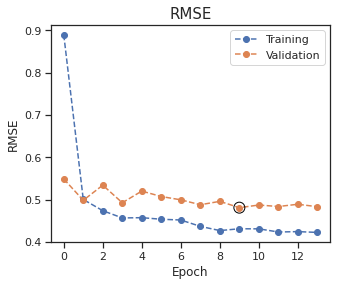

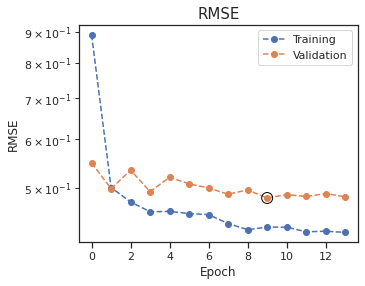

In [20]:
# plot train and test
train_losses, val_losses, train_rmse, val_rmse = result
ut.plot("RMSE", "RMSE", train_rmse, val_rmse, yscale='linear', save_path="/content/file0.svg")
ut.plot("RMSE", "RMSE", train_rmse, val_rmse, yscale='log')

In [21]:

path ="/content/checkpoints/train_loss.npy"
np.save(path, train_losses)
path ="/content/checkpoints/val_loss.npy"
np.save(path, val_losses)

# do you want to save a checkpoint run this chunk
!mkdir -p /content/drive/MyDrive/Colab/airbnb/data/logs/reviews/best2
!cp -r /content/checkpoints/ /content/drive/MyDrive/Colab/airbnb/data/logs/reviews/best2

In [22]:
model.load_state_dict(torch.load("/content/checkpoints/checkpoint.pt"))

<All keys matched successfully>

100%|██████████| 366/366 [03:24<00:00,  1.79it/s]


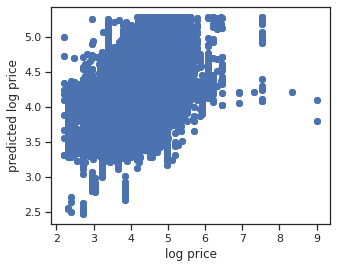

(array([0.5110925462231879], dtype=object), 0.0)


In [26]:
# show correlation
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt
from tqdm import tqdm

ys = []
ypreds = []

with torch.no_grad():
    model = model.eval()

    for ids, labels, masks in tqdm(valloader):
        ids, masks = ids.to(device), masks.to(device)
        y_pred = model(ids, masks)[0]
        y_pred = list(y_pred.detach().cpu().numpy())
        ypreds = ypreds + y_pred

        ys = ys + list(labels)


ys = np.array(ys)
ypreds = np.array(ypreds)
m = np.mean(ypreds)
from sklearn import linear_model
# reg = linear_model.LinearRegression()
# reg.fit(ypreds, ys)
# ypreds = ypreds * reg.coef_ + reg.intercept_ 
plt.figure(figsize=(5,4))
sns.set(style="ticks")
plt.scatter(ys, ypreds, c='#1f77b4')
plt.ylabel("predicted log price")
plt.xlabel("log price")
plt.scatter(ys, ypreds)
plt.savefig(str("/content/file0.svg"), bbox_inches='tight', format="svg", transparent=True)
plt.show()
print(pearsonr(ys, ypreds))

In [27]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(ys, ypreds)
print("The root mean squared error (MSE) on test set: {:.4f}".format(np.sqrt(mse)))

The root mean squared error (MSE) on test set: 0.4813


In [ ]:
import explainability_utils as explain
text = "This is a modest appartment, with a backyard location in the centre of downtown vienna"
attention = explain.pipeline(text, model, device)
explain.visualize_attention(text, attention)

78.2594223022461


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


# Generate embeddings

In [28]:
# load model
sys.path.append("/content/airbnb_price/models")
from language_model import LanguageBertNet
model = LanguageBertNet(fine_tune=True, with_attention_masks=True)
path = "/content/drive/MyDrive/Colab/airbnb/data/logs/reviews/best2/checkpoints/checkpoint.pt"
model.load_state_dict(torch.load(path))
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [35]:
input_ids, attention_masks, index = data['review_input_ids'], data['review_attention_masks'], data.index

In [36]:
# generate embeddings
embeddings = torch.empty((len(data), 100))
model.eval()
indices = []
with torch.no_grad():
    for i, (ids, masks, idx) in tqdm(enumerate(zip(input_ids, attention_masks, index))):
        ls = []
        single_ids, single_masks = torch.tensor(ids).to(device), torch.tensor(masks).to(device)
        embedding = model.genembeddings(single_ids, single_masks)
        embedding = embedding.detach().cpu().numpy()
        embeddings[i] = torch.tensor(np.mean(embedding, axis=0))
        indices = indices + [idx]
    embeddings[embeddings < 0] = 0 

11404it [23:13,  8.18it/s] 


In [37]:
# save embeddings in pandas dataframe
df = pd.Series(embeddings.numpy().tolist(), name="reviews", index=indices)
path = "/content/drive/MyDrive/Colab/airbnb/data/embeddings/reviews.pickle"
df.to_pickle(path)

## generate plots for valset

In [38]:
trainprice, valprice = traindf["log_price"], valdf["log_price"]
dataset = TensorDataset(torch.from_numpy(np.apply_along_axis(np.concatenate, 1, np.array(df.loc[val_ids])[:, np.newaxis])),
                        torch.tensor(valprice.to_numpy()))
dataloader = DataLoader(dataset, batch_size=128)

100%|██████████| 14/14 [00:00<00:00, 618.35it/s]


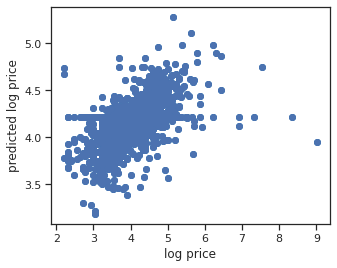

(array([0.5352325911406841], dtype=object), 1.972639651354486e-127)
The root mean squared error (MSE) on test set: 0.5700


In [41]:
# show correlation
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt
from tqdm import tqdm

ys = []
ypreds = []

with torch.no_grad():
    model = model.eval()

    for embeddings, labels in tqdm(dataloader):
        embeddings = embeddings.to(device).float()
        y_pred = model.prediction_from_mean(embeddings)
        y_pred = list(y_pred.detach().cpu().numpy())
        ypreds = ypreds + y_pred

        ys = ys + list(labels.numpy())

plt.figure(figsize=(5,4))
sns.set(style="ticks")
plt.scatter(ys, ypreds, c='#1f77b4')
plt.ylabel("predicted log price")
plt.xlabel("log price")
plt.scatter(ys, ypreds)
plt.savefig(str("/content/file0.svg"), bbox_inches='tight', format="svg", transparent=True)
plt.show()
print(pearsonr(ys, ypreds))


from sklearn.metrics import mean_squared_error

mse = mean_squared_error(ys, ypreds)
print("The root mean squared error (MSE) on test set: {:.4f}".format(np.sqrt(mse)))

# explainability

In [42]:
# load model
sys.path.append("/content/airbnb_price/models")
from language_model import LanguageBertNet
model = LanguageBertNet(fine_tune=True, with_attention_masks=True)
path = "/content/drive/MyDrive/Colab/airbnb/data/logs/reviews/best2/checkpoints/checkpoint.pt"
model.load_state_dict(torch.load(path))
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [119]:
i = 0
ypreds = []
model.eval()
model = model.to("cpu")
for input_ids, price, mask in tqdm(valset):
  with torch.no_grad():
      input_ids, mask = input_ids.unsqueeze(0), mask.unsqueeze(0)
      ypreds.append(model(input_ids, mask)[0].cpu().numpy().squeeze())
  i = i + 1
  if i > 100:
      break
ypreds = np.concatenate(np.arrypreds)

  0%|          | 100/54785 [00:32<4:54:05,  3.10it/s]


ValueError: ignored

In [122]:
ypreds = np.array(ypreds)

In [124]:
np.argsort(ypreds)

array([ 23,   2,  77,  59,  60,  53,  87,  69,   5,  28,  26,  17,  50,
         4,  91,  79,   0,  68,  24,  34,  84,  20,  57,  25,   3,  89,
        64,  19,  27,  94,  81,  15,  88,  11,  95,  13,  41,   8,  96,
        21,  93,   6,  48,  63,  73,  85,  49,  43,  65,  45,  39,  99,
        12,  36,   1,  22,   9,  33,  58,  31,  32,  37,  47,  67,  86,
        66,  14,  18,  38,  74,  92,  97,  90,  83,  98,  80,  29,  54,
        78,  42,  72, 100,  30,  70,  75,  62,   7,  51,  76,  71,  52,
        46,  44,  82,  61,  16,  55,  56,  40,  10,  35])

In [134]:
input_ids, price, mask = valset[61]
text = tokenizer.decode(input_ids[mask.bool()])
text = text[6:-6]
print(text)
print(np.exp(price))
#text = "performance fit, nice hostess."
# text = """
# a apartment, very clean and good location. anyone with a child will love this
# place because a small playground is just 2 minutes walking distance. the host was very friendly and helped us a lot. 
# if i ever travel to vienna again will make sure to rent this apartment.

# """
# text = "Statistics is the discipline that concerns the collection, organization, analysis, interpretation, and presentation of data. In applying statistics to a scientific, industrial, or social problem, it is conventional to begin with a statistical population or a statistical model to be studied."
# text = """WHAT. A. MOVIE It is just so well acted. You believe it all and want more of every single character!
# Clever, moralistic and entertaining. Hollywood has done very few consequential movies since (V For Vendetta, Captain Fantastic 
# and perhaps Watchmen..) so grab this one if you have not watched it.
# """
import explainability_utils as explain
text = text[0:512]
attention = explain.pipeline(text, model, "cpu")
attention = attention
explain.visualize_attention(text, attention, offset=0.2)

eva ’ s space is unique, gorgeous, and perfectly suited for a fruitful vacation in vienna. i stayed with a group of 5 and we would all stay again!
tensor(124.0000, dtype=torch.float64)
111.39556884765625
